#### Guia1: https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
#### Guia2: https://medium.com/@adriensieg/text-similarities-da019229c894

Por revisar mañana:
- https://stackoverflow.com/questions/64149670/how-to-compare-data-from-the-same-column-in-a-dataframe-pandas
- https://stackoverflow.com/questions/15173225/calculate-cosine-similarity-given-2-sentence-strings

In [1]:
#!pip install langdetect
#!pip install google_trans_new

In [8]:
import pandas as pd
import numpy as np
import unidecode
import unicodedata
#import mysql.connector
import re
import xlsxwriter
import datetime
from datetime import date

import nltk
from nltk.corpus import words

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from langdetect import detect
from google_trans_new import google_translator  

In [3]:
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('spanish'))
include_stopwords = {'mas', 'menos', 'null', 'none'}
stopwords |= include_stopwords
print("Total spanish stopwords: {}\n".format(len(stopwords)))
stopwords_en = set(nltk.corpus.stopwords.words('english'))
print("Total english stopwords: {}\n".format(len(stopwords_en)))

Total spanish stopwords: 317

Total english stopwords: 179



[nltk_data] Downloading package words to C:\Users\Cristian
[nltk_data]     Restrepo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Cristian
[nltk_data]     Restrepo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Cristian
[nltk_data]     Restrepo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Funciones para normalizar y tokenizar las palabras

#función para decodificar texto
def elimina_tildes(cadena):
  s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
  return s

def deco(text):
    if text is None :
        pass
    else:
        text = text.decode('unicode_escape').encode('iso8859-1').decode('utf8')
    return text

def clean_skills(text):
  text = re.sub('\"', '', text)
  text = re.sub('\}', '', text)
  text = re.sub(re.compile("{..: "),  '',    text)
  
  return text

def tokenize(text):
 #Remove text in square brackets, remove punctuation and remove words containing numbers.
 text = re.sub('\[.*?¿\]\%', ' ', text)
 text = re.sub('https://', '', text)
 text = re.sub('www.', '', text)
 text = re.sub('[‘’“”…«»]', '', text)
 text = re.sub(r'["\[\]\{\}\¿]', '', text)
 text = re.sub(r'_', ' ', text) 
 #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
 text = re.sub('\w*\d\w*', '', text)
 text = re.sub(r'b‘\‘', '', text)

 text = re.sub('\n', ' ', text)
 text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
 
 #eliminar caracteres que se repitan más de dos veces seguidas
 pattern = re.compile(r"(.)\1{2,}")
 text =pattern.sub(r"\1\1", text) 
 
 return text.split()
 
def remove_stop(tokens):
  #stopwords = ['de','para']
  return [t for t in tokens if t.lower() not in stopwords]

def remove_stop_en(tokens):
  #stopwords = ['de','para']
  return [t for t in tokens if t.lower() not in stopwords_en]
 
#def lemmatize(text):
# prueba = nlp(text)
# tokens = [word.lemma_ for word in prueba]
# return tokens
 
#def join(tokens):
# sentence = (" ").join(tokens)
# return sentence
 
pipeline = [str.lower,elimina_tildes,tokenize, remove_stop, remove_stop_en]
 
 
def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return ' '.join(tokens)

In [5]:
df = pd.read_excel('vacantes.xlsx')
df

,Id_vacante,Cargo,Descripcion,Habilidades,Nivel experiencia,Tipo empleo,# Solicitudes,Empresa,Sector,Fecha publicacion,Ubicacion,Ciudad,Pais,url_vacante
0,NaN,Ventas,empresa trans nacional con un amplio catálogo ...,NaN,NaN,PART_TIME,NaN,Grupo evolución global,NaN,2021-05-08T22:22:30.000Z,"Cali, Valle del Cauca, Colombia",Yotoco,CO,https://co.linkedin.com/jobs/view/ventas-at-gr...
1,NaN,Ruby on Rails Developer,Ruby on Rails Developer We are looking for a R...,NaN,Algo de responsabilidad,FULL_TIME,NaN,Jobsity,"Servicios y tecnologías de la información ,Seg...",2021-05-08T22:21:30.000Z,Colombia,NaN,CO,https://co.linkedin.com/jobs/view/ruby-on-rail...
2,NaN,Analista de Selección Bilingüe - Inglés LTM,En Colombia ESL nos encontramos en la búsqueda...,NaN,Algo de responsabilidad,FULL_TIME,NaN,Open Education,E-learning,2021-05-08T22:01:30.000Z,Área metropolitana de Bogotá D.C.,Bogotá,CO,https://co.linkedin.com/jobs/view/analista-de-...
3,NaN,Coordinador de marketing,Objetivo del cargo: Establecer estrategias que...,NaN,NaN,FULL_TIME,NaN,Confidencial,NaN,2021-05-08T21:40:59.000Z,"Bogotá, Distrito Capital, Colombia",Bogotá,CO,https://co.linkedin.com/jobs/view/coordinador-...
4,4446,Consulting Systems Engineer - P3,"Job DescriptionFortinet, a global leader and i...",NaN,Intermedio,FULL_TIME,NaN,Fortinet,"Servicios y tecnologías de la información ,Seg...",2021-05-08T21:19:54.000Z,"Bogotá, Distrito Capital, Colombia",Bogotá,CO,https://co.linkedin.com/jobs/view/consulting-s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,306154551,Analista de compras,RequisitosReconocida empresa del sector mueble...,NaN,Sin experiencia,FULL_TIME,NaN,MADERFORMAS,"Construcción,Dotación y selección de personal,...",2021-05-08T20:58:57.000Z,"Bogotá, San Andrés y Providencia, Colombia",San Andrés,CO,https://co.linkedin.com/jobs/view/analista-de-...
380,306149772,Analista de compras/comprador,RequisitosProfesional o estudiante de últimos ...,NaN,Sin experiencia,FULL_TIME,NaN,Grupo merpes sas,"Marketing y publicidad,Artículos de consumo,Re...",2021-05-08T20:58:57.000Z,"Cota, Cundinamarca, Colombia",Bogotá,CO,https://co.linkedin.com/jobs/view/analista-de-...
381,306149649,Líder Comercial,RequisitosSl research Colombia SAS empresa de ...,NaN,Algo de responsabilidad,FULL_TIME,NaN,SL RESEARCH COLOMBIA SAS,"Marketing y publicidad,Investigación de mercad...",2021-05-08T20:58:57.000Z,"Cali, Valle del Cauca, Colombia",Yotoco,CO,https://co.linkedin.com/jobs/view/l%C3%ADder-c...
382,306154533,Instalador | carpintería,RequisitosReconocida empresa del sector mueble...,NaN,Sin experiencia,FULL_TIME,NaN,MADERFORMAS,"Construcción,Dotación y selección de personal,...",2021-05-08T20:58:57.000Z,"Ibagué, Tolima, Colombia",Valle de San Juan,CO,https://co.linkedin.com/jobs/view/instalador-c...


In [6]:
df_prueba = df[['Cargo']].copy()
df_prueba.reset_index(inplace=True)
df_prueba

,index,Cargo
0,0,Ventas
1,1,Ruby on Rails Developer
2,2,Analista de Selección Bilingüe - Inglés LTM
3,3,Coordinador de marketing
4,4,Consulting Systems Engineer - P3
...,...,...
379,379,Analista de compras
380,380,Analista de compras/comprador
381,381,Líder Comercial
382,382,Instalador | carpintería


In [9]:
df_prueba['Cargo'] = df_prueba['Cargo'].apply(lambda x: prepare(x, pipeline))
df_prueba['Cargo1'] = df_prueba['Cargo'].apply(lambda x: 1 if detect(x) == 'en' else 0)
#translator = Translator()
#df['Cargo1'] = df['Cargo'].apply(translator.translate, src='es', dest='en')
df_prueba

,index,Cargo,Cargo1
0,0,ventas,0
1,1,ruby rails developer,1
2,2,analista seleccion bilingue - ingles ltm,0
3,3,coordinador marketing,0
4,4,consulting systems engineer -,1
...,...,...,...
379,379,analista compras,0
380,380,analista compras/comprador,0
381,381,lider comercial,0
382,382,instalador | carpinteria,0


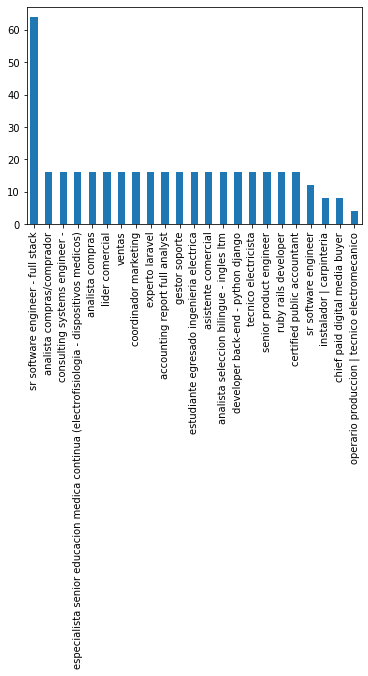

In [28]:
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#ax.bar(df_prueba['Cargo'])
#plt.show()
#df_prueba['Cargo'].sort_values(ascending=0)[:10].plot(kind='bar')
df_prueba['Cargo'].value_counts().plot.bar()

In [24]:
translator = google_translator()  
df_prueba['Cargo2'] = df_prueba['Cargo'].apply(lambda x: translator.translate(x, lang_src='en', lang_tgt='es'))
df_prueba

,index,Cargo,Cargo1,Cargo2
0,0,ventas,0,ventas
1,1,ruby rails developer,1,Desarrollador de Ruby Rails
2,2,analista seleccion bilingue - ingles ltm,0,Analista Selección Bilingue - Ingles LTM
3,3,coordinador marketing,0,coordinador marketing
4,4,consulting systems engineer -,1,Ingeniero de Sistemas de Consultoría -
...,...,...,...,...
379,379,analista compras,0,Analista Compras
380,380,analista compras/comprador,0,Analista Compras / comprador
381,381,lider comercial,0,Lider Comercial
382,382,instalador | carpinteria,0,Instalador | Carpinteria


In [29]:
df_prueba['Cargo2'] = df_prueba['Cargo2'].apply(lambda x: prepare(x, pipeline))
df_prueba

,index,Cargo,Cargo1,Cargo2
0,0,ventas,0,ventas
1,1,ruby rails developer,1,desarrollador ruby rails
2,2,analista seleccion bilingue - ingles ltm,0,analista seleccion bilingue - ingles ltm
3,3,coordinador marketing,0,coordinador marketing
4,4,consulting systems engineer -,1,ingeniero sistemas consultoria -
...,...,...,...,...
379,379,analista compras,0,analista compras
380,380,analista compras/comprador,0,analista compras / comprador
381,381,lider comercial,0,lider comercial
382,382,instalador | carpinteria,0,instalador | carpinteria


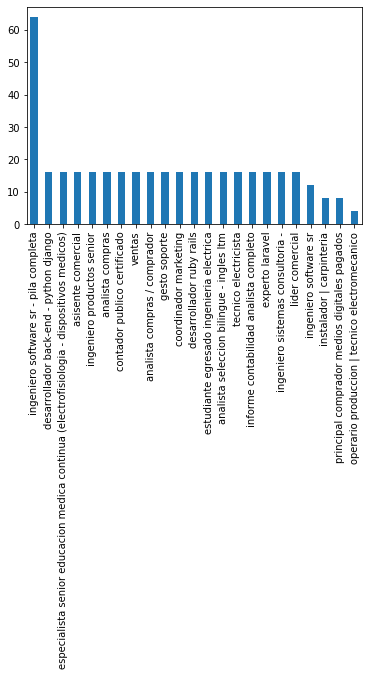

In [35]:
df_prueba['Cargo2'].value_counts().plot.bar()

In [15]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df_prueba.Cargo2.values)
features = vec.transform(df_prueba.Cargo2.values)

In [16]:
# for reproducibility
random_state = 0 
cls = MiniBatchKMeans(n_clusters=10, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [17]:
cls.predict(features)

array([0, 3, 7, 5, 8, 9, 7, 0, 1, 6, 1, 9, 0, 3, 1, 0, 1, 4, 2, 0, 2, 7,
       7, 1, 0, 3, 7, 5, 8, 9, 7, 0, 1, 1, 0, 1, 3, 9, 0, 1, 6, 4, 2, 2,
       0, 1, 7, 7, 0, 3, 7, 5, 8, 9, 7, 0, 1, 6, 1, 9, 0, 3, 1, 0, 1, 4,
       2, 0, 2, 7, 7, 1, 0, 3, 7, 5, 8, 9, 7, 0, 1, 1, 0, 1, 3, 9, 0, 1,
       6, 4, 2, 2, 0, 1, 7, 7, 0, 3, 7, 5, 8, 9, 7, 0, 1, 1, 0, 1, 3, 9,
       0, 1, 6, 4, 2, 2, 0, 1, 7, 7, 0, 3, 7, 5, 8, 9, 7, 0, 1, 1, 0, 1,
       3, 9, 0, 1, 6, 4, 2, 2, 0, 1, 7, 7, 0, 3, 7, 5, 8, 9, 7, 0, 1, 1,
       0, 1, 3, 9, 0, 1, 6, 4, 2, 2, 0, 1, 7, 7, 0, 3, 7, 5, 8, 9, 7, 0,
       3, 1, 1, 0, 9, 6, 1, 0, 1, 4, 0, 7, 7, 2, 0, 2, 0, 3, 7, 5, 8, 9,
       7, 0, 1, 1, 0, 1, 3, 9, 0, 1, 6, 4, 2, 2, 0, 1, 7, 7, 0, 3, 7, 5,
       8, 9, 7, 0, 3, 1, 1, 0, 9, 6, 1, 0, 1, 4, 0, 7, 7, 2, 0, 2, 0, 3,
       7, 5, 8, 9, 7, 0, 1, 1, 0, 1, 3, 9, 0, 1, 6, 4, 2, 2, 0, 1, 7, 7,
       0, 3, 7, 5, 8, 9, 7, 0, 1, 6, 1, 9, 0, 3, 1, 0, 1, 4, 2, 0, 2, 7,
       7, 1, 0, 3, 7, 5, 8, 9, 7, 0, 1, 6, 1, 9, 0,

In [18]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

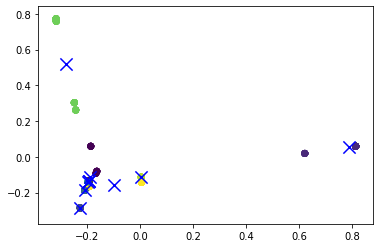

In [19]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')